# Photoz with Deep probabilistic neural network

- author : Sylvie Dagoret-Campagne
- creation : 2023/05/06

### Dependencies & Prerequisites


In [1]:
#@title Import { display-mode: "form" }

from IPython import display

from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()

from tensorflow import keras
from keras.models import Sequential,Model 
from keras.callbacks import ReduceLROnPlateau,EarlyStopping
from keras import layers
from keras import Input

import tensorflow_probability as tfp

sns.reset_defaults()
#sns.set_style('whitegrid')
#sns.set_context('talk')
sns.set_context(context='talk',font_scale=0.7)

%matplotlib inline

tfd = tfp.distributions
tfpl = tfp.layers

2023-05-06 20:30:28.707750: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import numpy as np
import pandas as pd
import os,sys
import h5py
import copy

In [3]:
def getdataerror(hf):
    key_sel = list(hf.keys())[0]
    group = hf.get(key_sel)
    
    mag_err_u_lsst = np.array(group.get("mag_err_u_lsst"))
    mag_err_g_lsst = np.array(group.get("mag_err_g_lsst"))
    mag_err_r_lsst = np.array(group.get("mag_err_r_lsst"))
    mag_err_i_lsst = np.array(group.get("mag_err_i_lsst"))
    mag_err_z_lsst = np.array(group.get("mag_err_z_lsst"))
    mag_err_y_lsst = np.array(group.get("mag_err_y_lsst"))
    mag_u_lsst =  np.array(group.get("mag_u_lsst"))
    mag_g_lsst =  np.array(group.get("mag_g_lsst"))
    mag_r_lsst =  np.array(group.get("mag_r_lsst"))
    mag_i_lsst =  np.array(group.get("mag_i_lsst"))
    mag_z_lsst =  np.array(group.get("mag_z_lsst"))
    mag_y_lsst =  np.array(group.get("mag_y_lsst"))
    redshift = np.array(group.get("redshift"))
    
    data = np.vstack((
                    mag_u_lsst, 
                    mag_g_lsst, 
                    mag_r_lsst, 
                    mag_i_lsst, 
                    mag_z_lsst,
                    mag_y_lsst,
                    mag_err_u_lsst, 
                    mag_err_g_lsst, 
                    mag_err_r_lsst, 
                    mag_err_i_lsst, 
                    mag_err_z_lsst,
                    mag_err_y_lsst,
                    redshift)) 
    data = data.T
    indexes_bad = np.where(data[:,0]>40)[0]
    datacut = np.delete(data,indexes_bad,axis=0)
    features = datacut[:,0:6]
    errors = datacut[:,6:-1]
    targets = datacut[:,-1]
    return features,errors,targets    

In [4]:
input_train_file_h5 = "../data/test_dc2_training_9816.hdf5"
input_test_file_h5 = "../data/test_dc2_validation_9816.hdf5"

In [5]:
hftrain =  h5py.File(input_train_file_h5, 'r') 
hftest =  h5py.File(input_test_file_h5, 'r') 

In [6]:
# swap train and test because more example in validation
x_train0,x_train_error0,y_train = getdataerror(hftest)
x_test0,x_test_error0,y_test = getdataerror(hftrain)

In [7]:
NBANDS = x_train0.shape[1]
NSAMPLES = x_train0.shape[0]
NSIM= 1

In [8]:
def simulatesamples(x,ex,nsim=NSIM):
    nsamples = x.shape[0]
    nbands = x.shape[1]
    
    all_samples = np.zeros((nsamples,nbands,nsim))
    for idx in range(nbands):
        mean = x[:,idx]
        sig = ex[:,idx]
        simdata = np.random.normal(mean, sig, (nsim,nsamples))
        all_samples[:,idx,: ] = simdata.T
    return all_samples  

In [9]:
train_data = simulatesamples(x_train0,x_train_error0,NSIM)
test_data = simulatesamples(x_test0,x_test_error0,NSIM)

In [10]:
mean = np.mean(train_data[:,:,0],axis=0)
std  = np.std(train_data[:,:,0],axis=0)

In [11]:
x_train0 = train_data[:,:,0]
x_test0 = test_data[:,:,0]

In [12]:
x_train0_norm = (x_train0-mean)/std
x_test0_norm = (x_test0-mean)/std

In [13]:
all_x_train_norm = []
all_x_test_norm = []
for isim in range(NSIM):
    x_train_norm = (train_data[:,:,isim] - mean)/std
    x_test_norm = (test_data[:,:,isim] - mean)/std
    all_x_train_norm.append(x_train_norm) 
    all_x_test_norm.append(x_test_norm) 

In [14]:
x_train = copy.deepcopy(all_x_train_norm[0])
x_test = copy.deepcopy(all_x_test_norm[0])
y_train = copy.deepcopy(y_train[:,np.newaxis])
y_test = copy.deepcopy(y_test[:,np.newaxis])

## presentation of results

In [15]:
def get_stats(z_spec,z_phot,slope=0.15):
    """
    input : 
       - z_spec : spectroscopic redshift or true redshift
       - z_phot : photo-z reedshift
       - slope : slope of line defining the outliers  3 x sigma_z with sigma_z = 5%, so slope = 3 x 0.05 = 0.15 
    """
    
    mask = np.abs((z_phot - z_spec)/(1 + z_spec)) > slope
    notmask = ~mask 
    
    # Standard Deviation of the predicted redshifts compared to the data:
    #-----------------------------------------------------------------
    std_result = np.std((z_phot - z_spec)/(1 + z_spec), ddof=1)
    print('Standard Deviation: %6.4f' % std_result)
    

    # Normalized MAD (Median Absolute Deviation):
    #------------------------------------------
    nmad = 1.48 * np.median(np.abs((z_phot - z_spec)/(1 + z_spec)))
    print('Normalized MAD: %6.4f' % nmad)

    # Percentage of delta-z > 0.15(1+z) outliers:
    #-------------------------------------------
    eta = np.sum(np.abs((z_phot - z_spec)/(1 + z_spec)) > 0.15)/len(z_spec)
    print('Delta z >0.15(1+z) outliers: %6.3f percent' % (100.*eta))
    
    # Median offset (normalized by (1+z); i.e., bias:
    #-----------------------------------------------
    bias = np.median(((z_phot - z_spec)/(1 + z_spec)))
    sigbias=std_result/np.sqrt(0.64*len(z_phot))
    print('Median offset: %6.3f +/- %6.3f' % (bias,sigbias))
    
    
     # overlay statistics with titles left-aligned and numbers right-aligned
    stats_txt = '\n'.join([
        'NMAD  = {:0.2f}'.format(nmad),
        'STDEV = {:0.2f}'.format(std_result),
        'BIAS  = {:0.2f}'.format(bias),
        'ETA   = {:0.2f}'.format(eta)
    ])
    
    
    return nmad,std_result,bias,eta,stats_txt

In [16]:
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

In [17]:
def plot_lines(zmin=0,zmax=3,zstep=0.05,slope=0.15):
    x = np.arange(zmin,zmax,zstep)
    outlier_upper = x + slope*(1+x)
    outlier_lower = x - slope*(1+x)
    return x,outlier_upper,outlier_lower

## Tensorflow callbacks

In [18]:
# Early Stopping Callback
earlystopping_cbk = EarlyStopping(monitor='loss', patience=20, min_delta=0, mode='auto', baseline=None, restore_best_weights=True)
reducelronplateau_cbk = ReduceLROnPlateau(monitor="val_loss",factor=0.1,patience=10)

In [19]:
callbacks_list = [reducelronplateau_cbk]

## The model

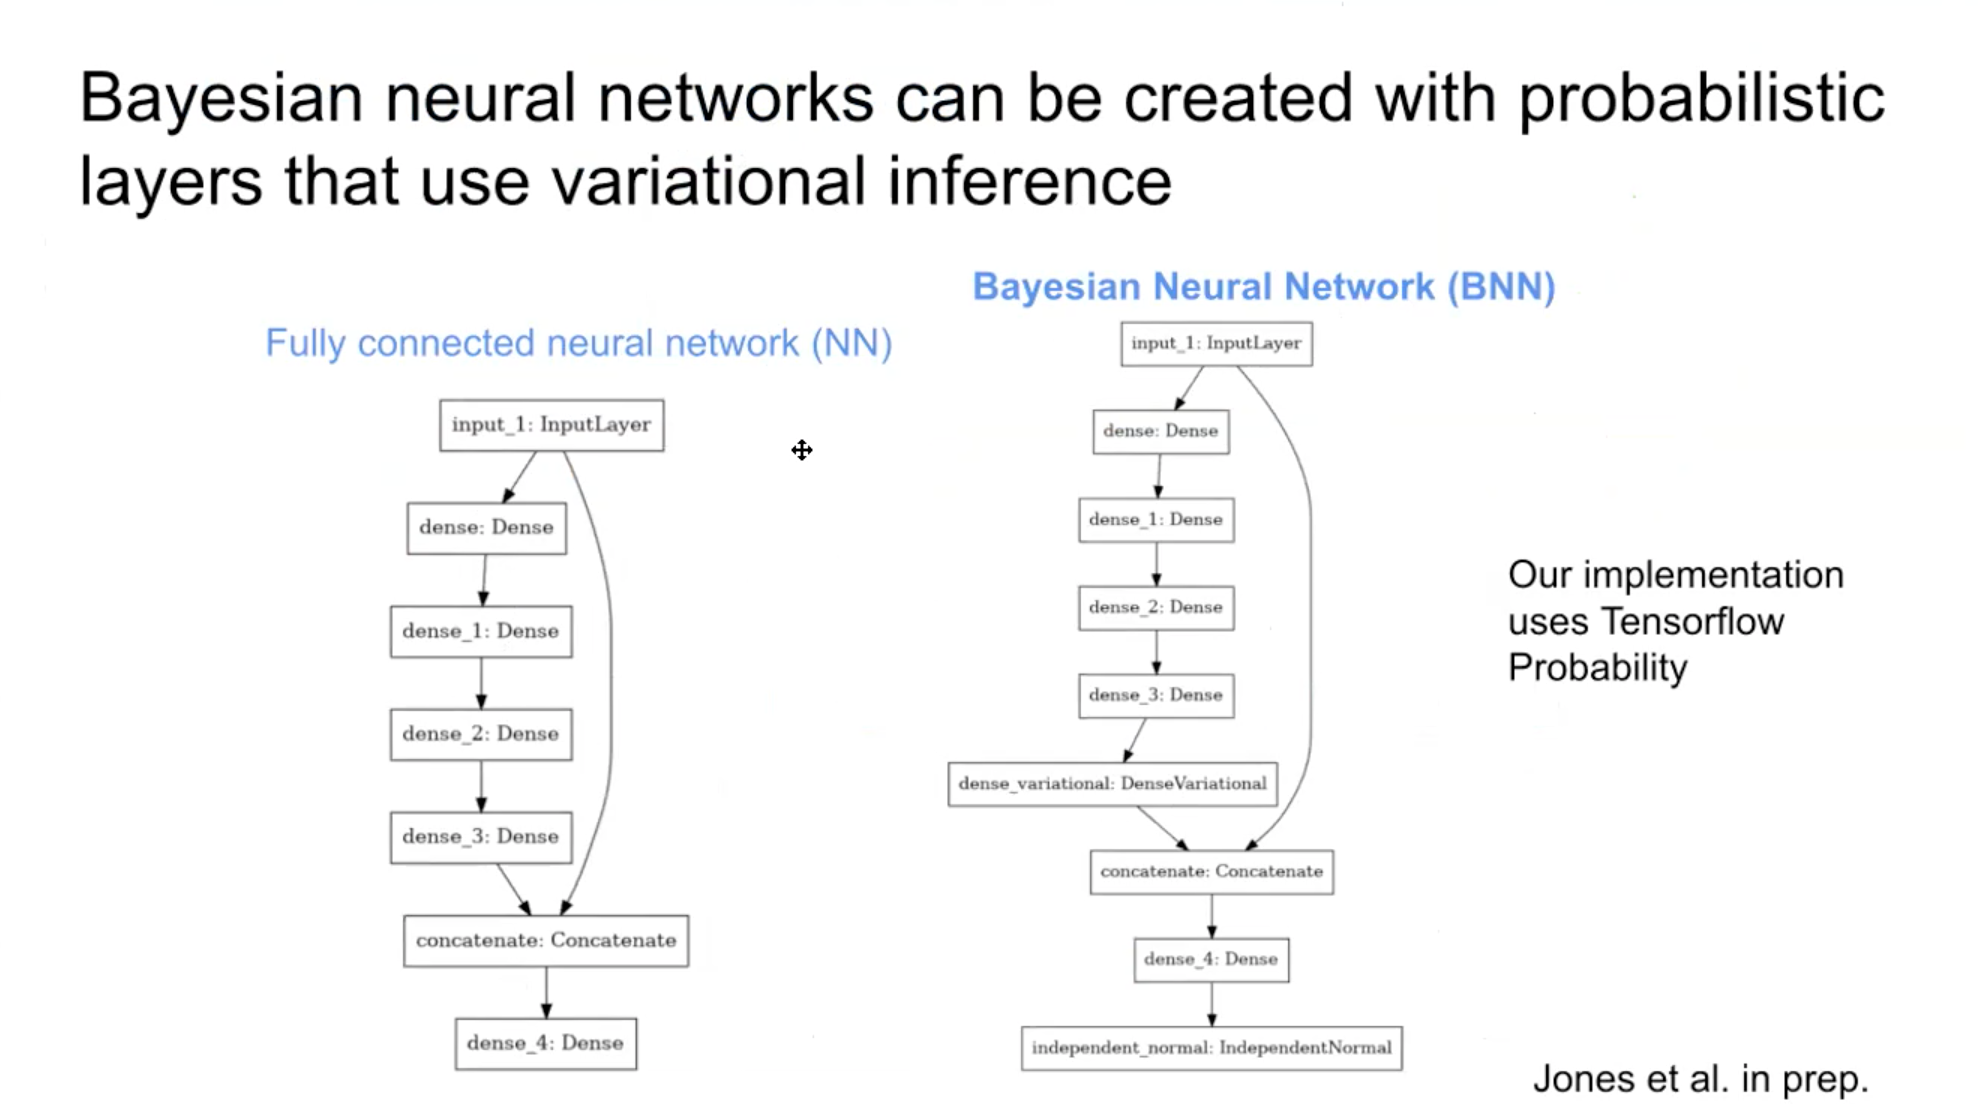

In [20]:
display.Image("Figs/Fig_BauesianNetwork.png")

## Motivation

Wouldn't it be great if we could use TFP to specify a probabilistic model then simply minimize the negative log-likelihood, i.e.,

In [21]:
negloglik = lambda y, rv_y: -rv_y.log_prob(y)

In [22]:
# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  c = np.log(np.expm1(1.))
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
  ])

In [23]:
# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1)),
  ])

# Model 1

In [24]:
def get_model_v1(n_samples):
  
  model = keras.models.Sequential()
  model.add(keras.layers.Input((6,), name="InputLayer"))
  model.add(keras.layers.Dense(32, activation='relu', name='Dense_n1'))
  model.add(keras.layers.Dense(64, activation='relu', name='Dense_n2'))
  model.add(keras.layers.Dense(64, activation='relu', name='Dense_n3'))
  model.add(keras.layers.Dense(32, activation="relu", name='Dense_n4'))
  model.add(tfp.layers.DenseVariational(32 + 32, posterior_mean_field, prior_trainable, kl_weight=1/n_samples))
  model.add(keras.layers.Dense(1,  name='Dense_n5'))
  model.add(tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)))
    
          
  #model.add(tfpl.DenseVariational(units=tfpl.IndependentNormal.params_size(1),
  #                            make_prior_fn=prior_trainable,
  #                            make_posterior_fn=posterior_mean_field,
  #                            kl_use_exact=False,
  #                            kl_weight=1/n_samples))

        # Aleatoric uncertainty
  #model.add(tfpl.IndependentNormal(1))
    
  
  model.compile(optimizer = tf.optimizers.Adam(learning_rate=0.01),
                loss      = negloglik )
  return model

In [25]:
n_samples = x_train.shape[0]
model1 = get_model_v1(n_samples)

In [26]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_n1 (Dense)            (None, 32)                224       
                                                                 
 Dense_n2 (Dense)            (None, 64)                2112      
                                                                 
 Dense_n3 (Dense)            (None, 64)                4160      
                                                                 
 Dense_n4 (Dense)            (None, 32)                2080      
                                                                 
 dense_variational (DenseVa  (None, 64)                6336      
 riational)                                                      
                                                                 
 Dense_n5 (Dense)            (None, 1)                 65        
                                                        

In [27]:
# Fit
history = model1.fit(x_train, y_train, validation_data = (x_test, y_test),epochs=50, verbose=1)

Epoch 1/50
593/593 [==============================] - 4s 3ms/step - loss: 1.2338 - val_loss: 0.9762
Epoch 2/50
593/593 [==============================] - 1s 2ms/step - loss: 0.9721 - val_loss: 0.9614
Epoch 3/50
593/593 [==============================] - 1s 2ms/step - loss: 0.9591 - val_loss: 0.9578
Epoch 4/50
593/593 [==============================] - 1s 2ms/step - loss: 1.0124 - val_loss: 0.9523
Epoch 5/50
593/593 [==============================] - 1s 2ms/step - loss: 0.9468 - val_loss: 0.9537
Epoch 6/50
593/593 [==============================] - 1s 2ms/step - loss: 0.9497 - val_loss: 0.9543
Epoch 7/50
593/593 [==============================] - 1s 2ms/step - loss: 0.9516 - val_loss: 0.9526
Epoch 8/50
593/593 [==============================] - 1s 2ms/step - loss: 0.9500 - val_loss: 0.9467
Epoch 9/50
593/593 [==============================] - 1s 3ms/step - loss: 0.9470 - val_loss: 0.9553
Epoch 10/50
593/593 [==============================] - 2s 3ms/step - loss: 0.9455 - val_loss: 0.9558

Text(0.5, 1.0, 'Model 1 : Loss')

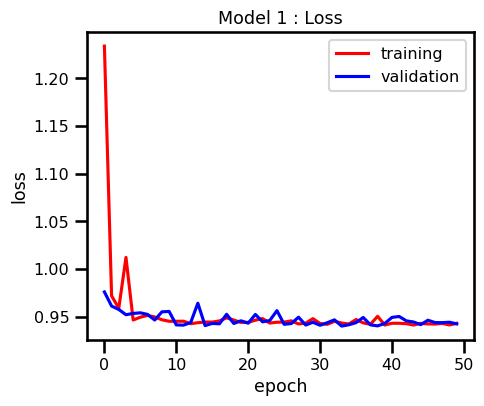

In [28]:
fig = plt.figure(figsize=(5,4))
ax  = fig.add_subplot(1,1,1)
ax.plot(history.history['loss'],'r-',label="training")
ax.plot(history.history['val_loss'],'b-',label="validation")
ax.legend()
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title("Model 1 : Loss")
#ax.set_yscale('log')

In [29]:
y_pred_train = model1(x_train).sample()
y_pred_test = model1(x_test).sample()

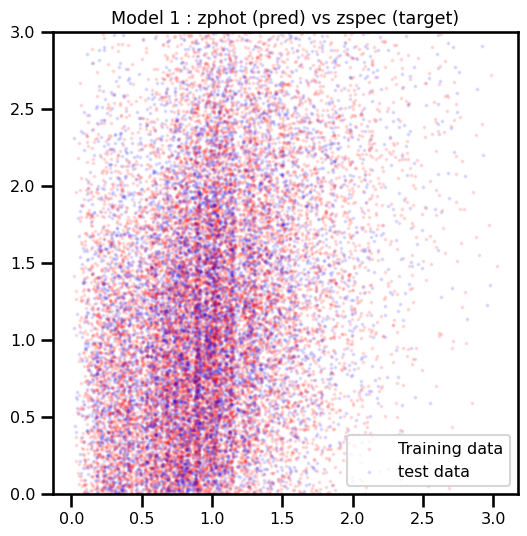

In [30]:
fig = plt.figure(figsize=(6, 6))
#------------------------------
ax = fig.add_subplot(1,1,1)
ax.scatter(y_train, y_pred_train, alpha=.1, c='r',s=2 ,label='Training data')
ax.scatter(y_test, y_pred_test, alpha=.1, c='b', s=2 ,label='test data')
ax.set_title("Model 1 : zphot (pred) vs zspec (target)")
ax.set_ylim(0,3)
ax.legend()

# Model 2

In [31]:
def get_model_v2(n_samples):
    
    input_tensor = keras.layers.Input((6,), name="InputLayer")
    x = keras.layers.Dense(32, activation='relu', name='Dense_n1')(input_tensor)
    x = keras.layers.Dense(64, activation='relu', name='Dense_n2')(x)
    x = keras.layers.Dense(64, activation='relu', name='Dense_n3')(x)
    x = keras.layers.Dense(32, activation="relu", name='Dense_n4')(x)
    x = tfp.layers.DenseVariational(32 + 32, posterior_mean_field, prior_trainable, kl_weight=1/n_samples,activation='sigmoid')(x)
    x = keras.layers.Dense(1,  name='Dense_n5')(x)
    output_proba = tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1))(x)
    
    model = Model(input_tensor,output_proba)
  
    model.compile(optimizer = tf.optimizers.Adam(learning_rate=0.01), loss      = negloglik )
    return model

In [32]:
n_samples = x_train.shape[0]
model2 = get_model_v2(n_samples)

In [33]:
model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 6)]               0         
                                                                 
 Dense_n1 (Dense)            (None, 32)                224       
                                                                 
 Dense_n2 (Dense)            (None, 64)                2112      
                                                                 
 Dense_n3 (Dense)            (None, 64)                4160      
                                                                 
 Dense_n4 (Dense)            (None, 32)                2080      
                                                                 
 dense_variational_1 (Dense  (None, 64)                6336      
 Variational)                                                    
                                                             

In [ ]:
# Fit
history = model2.fit(x_train, y_train, validation_data = (x_test, y_test),epochs=50, verbose=1)

Epoch 1/50
593/593 [==============================] - 4s 3ms/step - loss: 1.0108 - val_loss: 0.9522
Epoch 2/50
593/593 [==============================] - 1s 2ms/step - loss: 0.9508 - val_loss: 0.9546
Epoch 3/50
593/593 [==============================] - 1s 2ms/step - loss: 0.9465 - val_loss: 0.9392
Epoch 4/50
593/593 [==============================] - 1s 2ms/step - loss: 0.9440 - val_loss: 0.9415
Epoch 5/50
593/593 [==============================] - 1s 2ms/step - loss: 0.9457 - val_loss: 0.9409
Epoch 6/50
593/593 [==============================] - 1s 2ms/step - loss: 0.9400 - val_loss: 0.9382
Epoch 7/50
593/593 [==============================] - 2s 3ms/step - loss: 0.9416 - val_loss: 0.9409
Epoch 8/50
593/593 [==============================] - 2s 3ms/step - loss: 0.9407 - val_loss: 0.9412
Epoch 9/50
593/593 [==============================] - 2s 3ms/step - loss: 0.9387 - val_loss: 0.9381
Epoch 10/50
593/593 [==============================] - 1s 2ms/step - loss: 0.9377 - val_loss: 0.9350

In [ ]:
fig = plt.figure(figsize=(5,4))
ax  = fig.add_subplot(1,1,1)
ax.plot(history.history['loss'],'r-',label="training")
ax.plot(history.history['val_loss'],'b-',label="validation")
ax.legend()
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title("Model 2 Loss")
#ax.set_yscale('log')

In [ ]:
y_pred_train = model2(x_train).sample()
y_pred_test = model2(x_test).sample()

In [ ]:
fig = plt.figure(figsize=(6, 6))
#------------------------------
ax = fig.add_subplot(1,1,1)
ax.scatter(y_train, y_pred_train, alpha=.1, c='r', s=2,label='Training data')
ax.scatter(y_test, y_pred_test, alpha=.1, c='b',s=2 ,label='test data')
ax.set_title("Model 2 : zphot (pred) vs zspec (target)")
ax.set_ylim(0,3)
ax.legend()

# Model 3

In [ ]:
def get_model_v3(n_samples):
    
    input_tensor = keras.layers.Input((6,), name="InputLayer")
    x = keras.layers.Dense(32, activation='relu', name='Dense_n1')(input_tensor)
    x = keras.layers.Dense(64, activation='relu', name='Dense_n2')(x)
    x = keras.layers.Dense(128, activation='relu', name='Dense_n3')(x)
    x = keras.layers.Dense(64, activation="relu", name='Dense_n4')(x)
    x = tfp.layers.DenseVariational(64 + 64, posterior_mean_field, prior_trainable, kl_weight=1/n_samples,activation='sigmoid',name='DenseVariational64')(x)
    x = keras.layers.Dense(1,  name='Dense_n5')(x)
    
    x = tfpl.DenseVariational(units=tfpl.IndependentNormal.params_size(1),
                              make_prior_fn=prior_trainable,
                              make_posterior_fn=posterior_mean_field,
                              kl_use_exact=False,
                              kl_weight=1/n_samples)(x)

    # Aleatoric uncertainty    
    output_proba = tfpl.IndependentNormal(1)(x)
    
    
    
    model = Model(input_tensor,output_proba)
  
    model.compile(optimizer = tf.optimizers.Adam(learning_rate=0.01), loss      = negloglik )
    return model

In [ ]:
n_samples = x_train.shape[0]
model3 = get_model_v3(n_samples)

In [ ]:
model3.summary()

In [ ]:
# Fit
history = model3.fit(x_train, y_train, validation_data = (x_test, y_test),epochs=200, verbose=1,callbacks = callbacks_list)

In [ ]:
fig = plt.figure(figsize=(5,4))
ax  = fig.add_subplot(1,1,1)
ax.plot(history.history['loss'],'r-',label="training")
ax.plot(history.history['val_loss'],'b-',label="validation")
ax.legend()
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title("Model 3 : Loss")
#ax.set_yscale('log')

In [ ]:
y_pred_train = model3(x_train).sample()
y_pred_test = model3(x_test).sample()

In [ ]:
fig = plt.figure(figsize=(6, 6))
#------------------------------
ax = fig.add_subplot(1,1,1)
ax.scatter(y_train, y_pred_train, alpha=.1, c='r', s=2,label='Training data')
ax.scatter(y_test, y_pred_test, alpha=.1, c='b',s=2 ,label='test data')
ax.set_title("Model 3 : zphot (pred) vs zspec (target)")
ax.set_ylim(0,3)
ax.legend()

In [ ]:
z_spec = y_test
z_phot = y_pred_test
nmad,std_result,bias,eta,stats_txt = get_stats(z_spec,z_phot,slope=0.15)

In [ ]:
x,outlier_upper,outlier_lower = plot_lines(zmin=0,zmax=3,zstep=0.05,slope=0.15)

In [ ]:
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(1,1,1)
ax.scatter(z_spec,z_phot,marker='.',c="b",s=30,alpha=0.1)
ax.text(0.05, 0.95, stats_txt, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.set_xlabel("$z_{spec}$ (true target value)")
ax.set_ylabel("$z_{phot}$ (predicted target value)")
ax.set_title("DNN-probabilistic (model 3) : photometric redshift vs spectroscopic redshift")
ax.plot(x,outlier_upper,'k:')
ax.plot(x,outlier_lower,'k:')
ax.set_ylim(0,3)
ax.set_xlim(0,3)

# Model 4

In [ ]:
def get_model_v4(n_samples):
    
    input_tensor = keras.layers.Input((6,), name="InputLayer")
    x = keras.layers.Dense(32, activation='relu', name='Dense_n1')(input_tensor)
    x = keras.layers.Dense(64, activation='relu', name='Dense_n2')(x)
    x = keras.layers.Dense(128, activation='relu', name='Dense_n3')(x)
    x = keras.layers.Dense(64, activation="relu", name='Dense_n4')(x)
    x = tfp.layers.DenseVariational(64 + 64, posterior_mean_field, prior_trainable, kl_weight=1/n_samples,activation='sigmoid',name='DenseVariational64')(x)
    
    
    concatenated = keras.layers.concatenate([x,input_tensor],axis=-1)
    #
    x = keras.layers.Dense(2, activation="relu", name='Dense_n5')(concatenated) # need activation to stabilize, unit =2 --> loss 0.67
    #x = keras.layers.Dense(1, name='Dense_n5')(concatenated)
    
    x = tfpl.DenseVariational(units=tfpl.IndependentNormal.params_size(1),
                              make_prior_fn=prior_trainable,
                              make_posterior_fn=posterior_mean_field,
                              kl_use_exact=False,
                              kl_weight=1/n_samples)(x)

    # Aleatoric uncertainty
    #output_proba = tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1))(x)
    
    output_proba = tfpl.IndependentNormal(1)(x)
    
    
    
    model = Model(input_tensor,output_proba)
  
    model.compile(optimizer = tf.optimizers.Adam(learning_rate=0.01), loss      = negloglik )
    return model

In [ ]:
n_samples = x_train.shape[0]
model4 = get_model_v4(n_samples)

In [ ]:
model4.summary()

In [ ]:
# Fit
history = model4.fit(x_train, y_train, validation_data = (x_test, y_test),epochs=200, verbose=1,callbacks = callbacks_list)

In [ ]:
fig = plt.figure(figsize=(5,4))
ax  = fig.add_subplot(1,1,1)
ax.plot(history.history['loss'],'r-',label="training")
ax.plot(history.history['val_loss'],'b-',label="validation")
ax.legend()
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title("Model 4 : Loss")
#ax.set_yscale('log')

In [ ]:
y_pred_train = model4(x_train).sample()
y_pred_test = model4(x_test).sample()

In [ ]:
fig = plt.figure(figsize=(6, 6))
#------------------------------
ax = fig.add_subplot(1,1,1)
ax.scatter(y_train, y_pred_train, alpha=.1, c='r', s=2,label='Training data')
ax.scatter(y_test, y_pred_test, alpha=.1, c='b', s=2,label='test data')
ax.set_title("Model 4 : zphot (pred) vs zspec (target)")
ax.set_ylim(0,3)
ax.legend()

In [ ]:
z_spec = y_test
z_phot = y_pred_test
nmad,std_result,bias,eta,stats_txt = get_stats(z_spec,z_phot,slope=0.15)

In [ ]:
x,outlier_upper,outlier_lower = plot_lines(zmin=0,zmax=3,zstep=0.05,slope=0.15)

In [ ]:
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(1,1,1)
ax.scatter(z_spec,z_phot,marker='.',c="b",s=30,alpha=0.1)
ax.text(0.05, 0.95, stats_txt, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.set_xlabel("$z_{spec}$ (true target value)")
ax.set_ylabel("$z_{phot}$ (predicted target value)")
ax.set_title("DNN-probabilistic (model 4) :photometric redshift vs spectroscopic redshift")
ax.plot(x,outlier_upper,'k:')
ax.plot(x,outlier_lower,'k:')
ax.set_ylim(0,3)
ax.set_xlim(0,3)

# Model 5

In [ ]:
def get_model_v5(n_samples):
    
    input_tensor = keras.layers.Input((6,), name="InputLayer")
    x = keras.layers.Dense(16, activation='relu', name='Dense_n1')(input_tensor)
    x = keras.layers.Dense(32, activation='relu', name='Dense_n2')(x)
    x = keras.layers.Dense(64, activation='relu', name='Dense_n3')(x)
    x = keras.layers.Dense(32, activation="relu", name='Dense_n4')(x)
    x = tfp.layers.DenseVariational(32 + 32, posterior_mean_field, prior_trainable, kl_weight=1/n_samples,activation='sigmoid',name='DenseVariational32')(x)
    x = keras.layers.Dense(1,  name='Dense_n5')(x)
    
    x = tfpl.DenseVariational(units=tfpl.IndependentNormal.params_size(1),
                              make_prior_fn=prior_trainable,
                              make_posterior_fn=posterior_mean_field,
                              kl_use_exact=False,
                              kl_weight=1/n_samples)(x)

    # Aleatoric uncertainty    
    output_proba = tfpl.IndependentNormal(1)(x)
    
    
    model = Model(input_tensor,output_proba)
  
    model.compile(optimizer = tf.optimizers.Adam(learning_rate=0.01), loss      = negloglik )
    return model

In [ ]:
n_samples = x_train.shape[0]
model5 = get_model_v5(n_samples)

In [ ]:
model5.summary()

In [ ]:
# Fit
history = model5.fit(x_train, y_train, validation_data = (x_test, y_test),epochs=200, verbose=1,callbacks = callbacks_list)

In [ ]:
fig = plt.figure(figsize=(5,4))
ax  = fig.add_subplot(1,1,1)
ax.plot(history.history['loss'],'r-',label="training")
ax.plot(history.history['val_loss'],'b-',label="validation")
ax.legend()
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title("Model 5 : Loss")
#ax.set_yscale('log')

In [ ]:
y_pred_train = model5(x_train).sample()
y_pred_test = model5(x_test).sample()

In [ ]:
fig = plt.figure(figsize=(6, 6))
#------------------------------
ax = fig.add_subplot(1,1,1)
ax.scatter(y_train, y_pred_train, alpha=.1, c='r', s=2,label='Training data')
ax.scatter(y_test, y_pred_test, alpha=.1, c='b', s=2,label='test data')
ax.set_title("Model 5 : zphot (pred) vs zspec (target)")
ax.set_ylim(0,3)
ax.legend()

In [ ]:
z_spec = y_test
z_phot = y_pred_test
nmad,std_result,bias,eta,stats_txt = get_stats(z_spec,z_phot,slope=0.15)

In [ ]:
x,outlier_upper,outlier_lower = plot_lines(zmin=0,zmax=3,zstep=0.05,slope=0.15)

In [ ]:
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(1,1,1)
ax.scatter(z_spec,z_phot,marker='.',c="b",s=30,alpha=0.1)
ax.text(0.05, 0.95, stats_txt, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.set_xlabel("$z_{spec}$ (true target value)")
ax.set_ylabel("$z_{phot}$ (predicted target value)")
ax.set_title("DNN-probabilistic (model 5) :photometric redshift vs spectroscopic redshift")
ax.plot(x,outlier_upper,'k:')
ax.plot(x,outlier_lower,'k:')
ax.set_ylim(0,3)
ax.set_xlim(0,3)

# Model 6

In [ ]:
def get_model_v6(n_samples):
    
    input_tensor = keras.layers.Input((6,), name="InputLayer")
    x = keras.layers.Dense(8, activation='relu', name='Dense_n1')(input_tensor)
    x = keras.layers.Dense(16, activation='relu', name='Dense_n2')(x)
    x = keras.layers.Dense(32, activation='relu', name='Dense_n3')(x)
    x = keras.layers.Dense(16, activation="relu", name='Dense_n4')(x)
    x = tfp.layers.DenseVariational(16 + 16, posterior_mean_field, prior_trainable, kl_weight=1/n_samples,activation='sigmoid',name='DenseVariational16')(x)
    x = keras.layers.Dense(1,  name='Dense_n5')(x)
    
    x = tfpl.DenseVariational(units=tfpl.IndependentNormal.params_size(1),
                              make_prior_fn=prior_trainable,
                              make_posterior_fn=posterior_mean_field,
                              kl_use_exact=False,
                              kl_weight=1/n_samples)(x)

    # Aleatoric uncertainty    
    output_proba = tfpl.IndependentNormal(1)(x)
    
    
    model = Model(input_tensor,output_proba)
  
    model.compile(optimizer = tf.optimizers.Adam(learning_rate=0.01), loss      = negloglik )
    return model

In [ ]:
n_samples = x_train.shape[0]
model6 = get_model_v6(n_samples)

In [ ]:
model6.summary()

In [ ]:
# Fit
history = model6.fit(x_train, y_train, validation_data = (x_test, y_test),epochs=200, verbose=1,callbacks = callbacks_list)

In [ ]:
fig = plt.figure(figsize=(5,4))
ax  = fig.add_subplot(1,1,1)
ax.plot(history.history['loss'],'r-',label="training")
ax.plot(history.history['val_loss'],'b-',label="validation")
ax.legend()
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title("Model 6 : Loss")
#ax.set_yscale('log')

In [ ]:
y_pred_train = model6(x_train).sample()
y_pred_test = model6(x_test).sample()

In [ ]:
fig = plt.figure(figsize=(6, 6))
#------------------------------
ax = fig.add_subplot(1,1,1)
ax.scatter(y_train, y_pred_train, alpha=.1, c='r', s=2,label='Training data')
ax.scatter(y_test, y_pred_test, alpha=.1, c='b', s=2,label='test data')
ax.set_title("Model 6 : zphot (pred) vs zspec (target)")
ax.set_ylim(0,3)
ax.legend()

In [ ]:
z_spec = y_test
z_phot = y_pred_test
nmad,std_result,bias,eta,stats_txt = get_stats(z_spec,z_phot,slope=0.15)

In [ ]:
x,outlier_upper,outlier_lower = plot_lines(zmin=0,zmax=3,zstep=0.05,slope=0.15)

In [ ]:
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(1,1,1)
ax.scatter(z_spec,z_phot,marker='.',c="b",s=30,alpha=0.1)
ax.text(0.05, 0.95, stats_txt, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.set_xlabel("$z_{spec}$ (true target value)")
ax.set_ylabel("$z_{phot}$ (predicted target value)")
ax.set_title("DNN-probabilistic (model 6) :photometric redshift vs spectroscopic redshift")
ax.plot(x,outlier_upper,'k:')
ax.plot(x,outlier_lower,'k:')
ax.set_ylim(0,3)
ax.set_xlim(0,3)